In [1]:
likelihood_times_file = "../out/likelihood-times.csv"
transform_times_file = "../out/transform-times.csv"
config_file = "../config.yaml"
model_file = "../model.yaml"
plot_data_output = "../out/plot-data.csv"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from treeflow_pipeline.util import yaml_input

## Simulation configuration

In [3]:
yaml_input(config_file)

{'model_file': 'model.yaml',
 'taxon_counts': [8, 16, 32, 64],
 'replicates': 30,
 'working_directory': 'out',
 'sampling_window': 2.0,
 'sample_count': 1000,
 'height_scale': 0.1,
 'sequence_length': 1000}

### Simulation model

In [4]:
yaml_input(model_file)

{'tree': {'coalescent_constant': {'pop_size': 4.0}},
 'clock': {'strict': {'clock_rate': 0.01}},
 'site': 'none',
 'substitution': {'hky': {'frequencies': [0.24, 0.26, 0.27, 0.23],
   'kappa': 2.0}}}

## Likelihood benchmarks
Note: plots have different scales

In [5]:
likelihood_times = pd.read_csv(likelihood_times_file).drop(columns="Unnamed: 0", errors="ignore")
likelihood_times.columns

Index(['likelihood_time', 'gradient_time', 'taxon_count', 'seed', 'method'], dtype='object')

[8, 16, 32, 64]

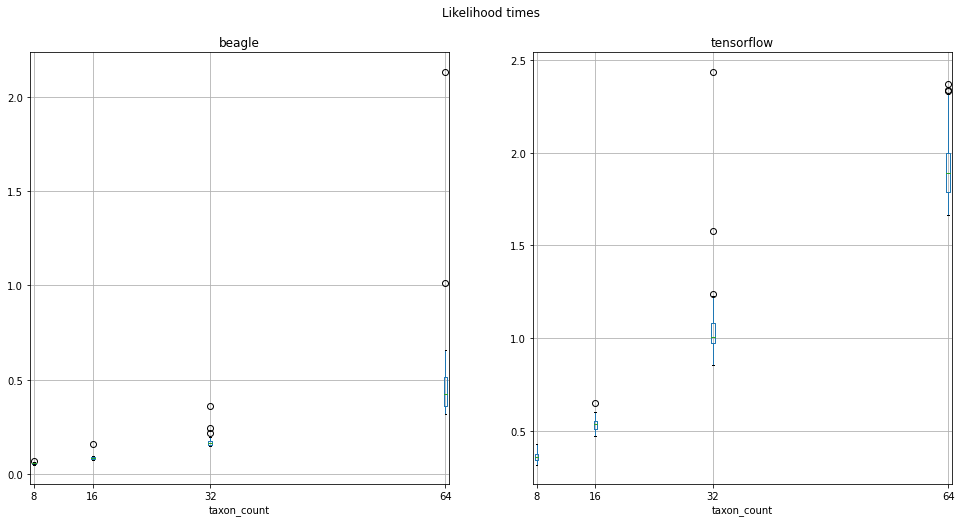

In [22]:
likelihood_grouped = likelihood_times.groupby("method")
fig, axs = plt.subplots(ncols=len(likelihood_grouped), figsize=(16, 8))
taxon_counts = sorted(likelihood_times.taxon_count.unique())

for ax, (method, data) in zip(axs, likelihood_grouped):
    data.boxplot(
        column="likelihood_time",
        by="taxon_count",
        positions=taxon_counts,
        ax=ax
    )
    ax.set_title(method)
    
plt.suptitle("Likelihood times");

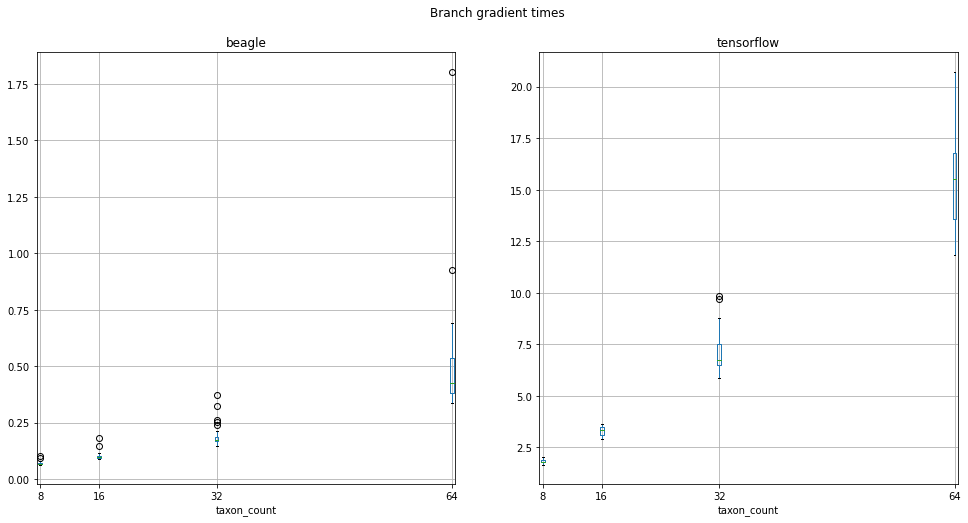

In [23]:
fig, axs = plt.subplots(ncols=len(likelihood_grouped), figsize=(16, 8))

for ax, (method, data) in zip(axs, likelihood_grouped):
    data.boxplot(
        column="gradient_time",
        by="taxon_count",
        positions=taxon_counts,
        ax=ax
    )
    ax.set_title(method)
    
plt.suptitle("Branch gradient times");

## Ratio transform benchmarks

In [8]:
transform_times = pd.read_csv(transform_times_file).drop(columns="Unnamed: 0", errors="ignore")
transform_times.columns

Index(['forward_time', 'gradient_time', 'taxon_count', 'seed', 'method'], dtype='object')

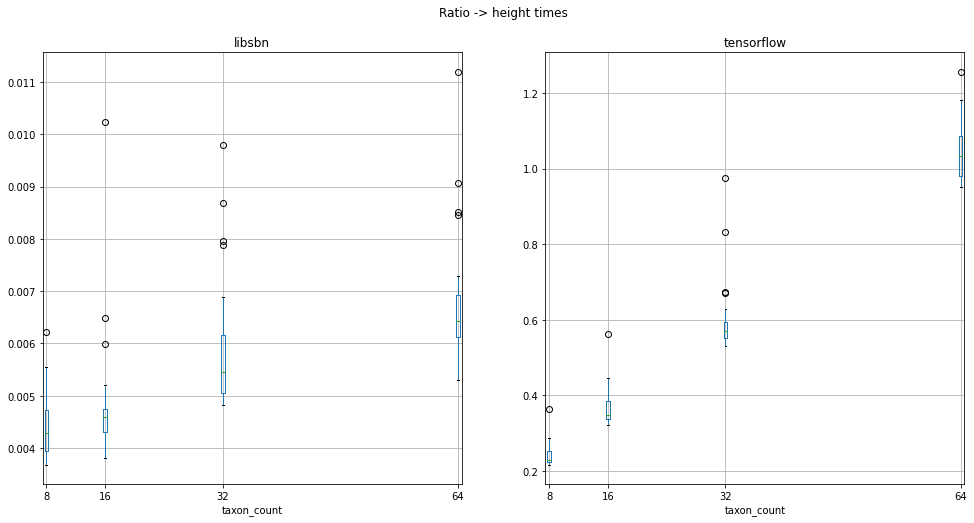

In [24]:
transform_grouped = transform_times.groupby("method")
fig, axs = plt.subplots(ncols=len(transform_grouped), figsize=(16, 8))

for ax, (method, data) in zip(axs, transform_grouped):
    data.boxplot(
        column="forward_time",
        by="taxon_count",
        positions=taxon_counts,
        ax=ax
    )
    ax.set_title(method)
    
plt.suptitle("Ratio -> height times");

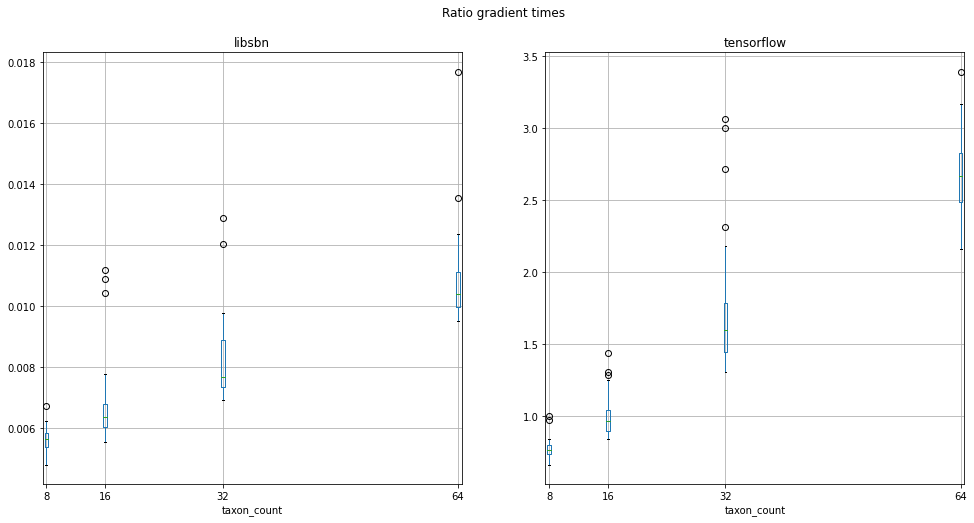

In [25]:
fig, axs = plt.subplots(ncols=len(transform_grouped), figsize=(16, 8))

for ax, (method, data) in zip(axs, transform_grouped):
    data.boxplot(
        column="gradient_time",
        by="taxon_count",
        positions=taxon_counts,
        ax=ax
    )
    ax.set_title(method)
    
plt.suptitle("Ratio gradient times");

## Summary

In [11]:
likelihood_times_to_merge = ( likelihood_times
    .pipe(lambda df: df.replace(dict(method="beagle"), "libsbn/beagle"))
    .pipe(lambda df: df.rename(columns=dict(gradient_time="branch_gradient_time")))
)
transform_times_to_merge = ( transform_times
    .pipe(lambda df: df.replace(dict(method="libsbn"), "libsbn/beagle"))
    .pipe(lambda df: df.rename(columns=dict(gradient_time="ratio_gradient_time", forward_time="ratio_to_height_time")))
)
merged = pd.merge(likelihood_times_to_merge, transform_times_to_merge)
merged.columns

Index(['likelihood_time', 'branch_gradient_time', 'taxon_count', 'seed',
       'method', 'ratio_to_height_time', 'ratio_gradient_time'],
      dtype='object')

In [12]:
melted = merged.melt(id_vars=["method", "seed", "taxon_count"], var_name="computation", value_name="time")
melted.to_csv(plot_data_output, index=False)
melted.columns

Index(['method', 'seed', 'taxon_count', 'computation', 'time'], dtype='object')

### Same (log) scale

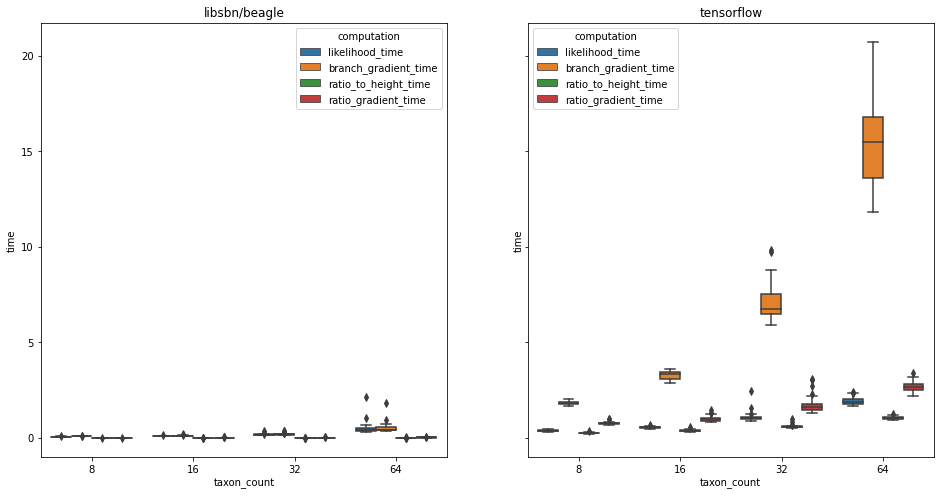

In [13]:
melted_grouped = melted.groupby("method")
fig, axs = plt.subplots(ncols=len(melted_grouped), figsize=(16, 8), sharey=True)

for ax, (method, data) in zip(axs, melted_grouped):
    ax.set_title(method)
    sns.boxplot(x="taxon_count", y="time", hue="computation", data=data, ax=ax)

### Independent scales

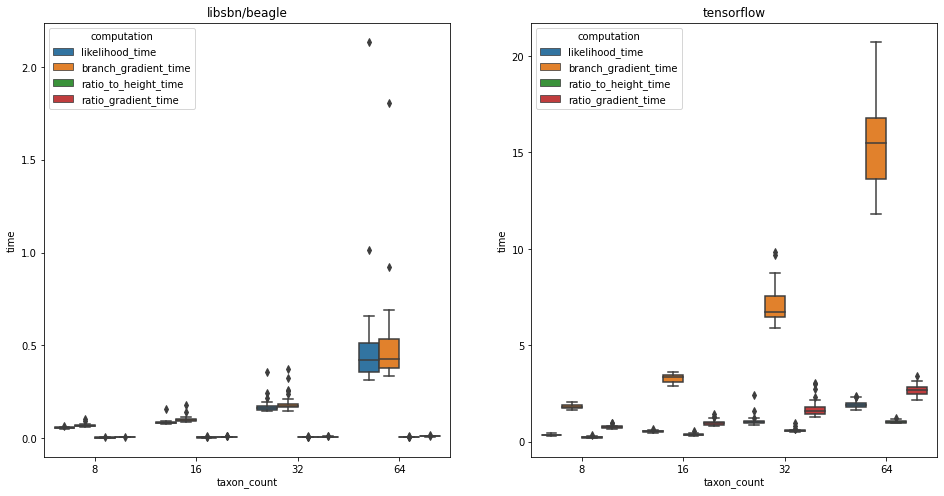

In [14]:
fig, axs = plt.subplots(ncols=len(melted_grouped), figsize=(16, 8))

for ax, (method, data) in zip(axs, melted_grouped):
    sns.boxplot(x="taxon_count", y="time", hue="computation", data=data, ax=ax)
    ax.set_title(method)